In [24]:
#import libraries
import re
import csv
import bz2
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
from nltk.corpus import wordnet, stopwords

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report


In [2]:
#convert fasttext to csv
#this is for the testing file
input_file = "test.ft.txt.bz2"
output_file = "amazon_reviews_test.csv"

if output_file:
    print(f"Data has been successfuly converted to {output_file}!")
else:
    with bz2.open(input_file, 'rt', encoding='ISO-8859-1') as infile, open(output_file, 'w', newline='', encoding='utf-8') as outfile:
        writer = csv.writer(outfile)
        writer.writerow(["Label", "Title", "Review"])

        for each_line in infile:
            parts = each_line.split(" ", 1)
            label = parts[0].replace("__label__", "")

            text = parts[1].strip()
            if ":" in text:
                title, review = text.split(":", 1)
                title = title.strip()
                review = review.strip()
            else:
                title = None
                review = text
            writer.writerow([label,title,review])
    print(f"Data has been successfuly converted to {output_file}!")


Data has been successfuly converted to amazon_reviews_test.csv!


In [ ]:
#convert fasttext to csv
#this is for the training file
input_file = "train.ft.txt.bz2"
output_file = "amazon_reviews_train.csv"

with bz2.open(input_file, 'rt', encoding='utf-8') as infile, open(output_file, 'w', newline='', encoding='utf-8') as outfile:
    writer = csv.writer(outfile)
    writer.writerow(["Label", "Title", "Review"])

    for each_line in infile:
        parts = each_line.split(" ", 1)
        label = parts[0].replace("__label__", "")

        text = parts[1].strip()
        if ":" in text:
            title, review = text.split(":", 1)
            title = title.strip()
            review = review.strip()
        else:
            title = None
            review = text
        writer.writerow([label,title,review])
print(f"Data has been successfuly converted to {output_file}!")


Data has been successfuly converted to amazon_reviews_train.csv!


In [11]:
#use pandas to read CSV file into a dataframe
df = pd.read_csv("amazon_reviews_test.csv")
# data_train = pd.read_csv("amazon_reviews_train.csv")
print("You now have your data in tabular format!")

You now have your data in tabular format!


In [ ]:
#inspect first row in test dataset
df['Review'].iloc[0]

'My lovely Pat has one of the GREAT voices of her generation. I have listened to this CD for YEARS and I still LOVE IT. When I\'m in a good mood it makes me feel better. A bad mood just evaporates like sugar in the rain. This CD just oozes LIFE. Vocals are jusat STUUNNING and lyrics just kill. One of life\'s hidden gems. This is a desert isle CD in my book. Why she never made it big is just beyond me. Everytime I play this, no matter black, white, young, old, male, female EVERYBODY says one thing "Who was that singing ?"'

In [20]:
#clean data-lower case, remove expressions and punctuations, remove trailing spaces
def clean_review(review):
    review = review.lower()
    review = re.sub(r'\d+', '', review)
    review = re.sub(r'[^\w\s]', '', review)
    review = re.sub(r'_', '', review)
    review = review.strip()
    return review


In [21]:
#apply clean function to clean reviews
df['Clean Review'] = df['Review'].apply(clean_review)


In [ ]:
# Check for missing titles, reviews, or both
missing_title = df[df['Title'].isna() | (df['Title'].str.strip() == '')]
missing_review = df[df['Clean Review'].isna() | (df['Clean Review'].str.strip() == '')]
missing_both = df[
    (df['Title'].isna() | (df['Title'].str.strip() == '')) &
    (df['Clean Review'].isna() | (df['Clean Review'].str.strip() == ''))
]  

# Insights
print(f"Rows with missing titles: {len(missing_title)}")
print(f"Rows with missing reviews: {len(missing_review)}")
print(f"Rows with both missing: {len(missing_both)}")

missing_title.to_csv("missing_titles.csv", index=False)
missing_review.to_csv("missing_reviews.csv", index=False)
missing_both.to_csv("missing_both.csv", index=False)

Rows with missing titles: 88
Rows with missing reviews: 0
Rows with both missing: 0


In [19]:
missing_title.head()

,Label,Title,Review,Clean Review
205,2,NaN,Awesome.... simply awesome. I couldn't put thi...,awesome simply awesome i couldnt put this down...
765,1,NaN,\: If I could give this a negative rating I wo...,if i could give this a negative rating i would...
2703,1,NaN,Who is Joe Nickell? What are his qualification...,who is joe nickell what are his qualifications...
10875,1,NaN,None the palace of pleasure volume l is not wo...,none the palace of pleasure volume l is not wo...
15427,2,NaN,): When this cd came out I was a pizza deliver...,when this cd came out i was a pizza delivery d...


In [22]:
sentiment_distribution = df['Label'].value_counts()
print(sentiment_distribution)


Label
2    200000
1    200000
Name: count, dtype: int64


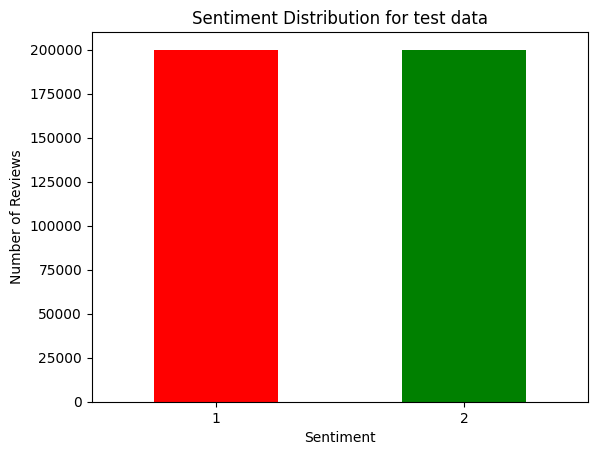

In [23]:
sentiment_distribution.plot(kind='bar', color=['red', 'green'])
plt.title('Sentiment Distribution for test data')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.xticks(ticks=[0, 1], labels=['1', '2'], rotation=0)
plt.show()

In [ ]:
# Calculate review length (word count)
df['review_length'] = df['Review'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)

average_lengths = df.groupby('Label')['review_length'].mean()

print("Average review length by label:")
print(average_lengths)

# Compare
if average_lengths[1] > average_lengths[2]:
    print("Negative (label 1) reviews are longer on average than Postive (label 2) reviews.")
elif average_lengths[1] < average_lengths[2]:
    print("Positive (label 2) reviews are longer on average than Negative (label 1) reviews.")
else:
    print("Positive and Negative reviews are the same length on average.")

Average review length by label:
Label
1    77.045240
2    71.236605
Name: review_length, dtype: float64
Negative (label 1) reviews are longer on average than Postive (label 2) reviews.


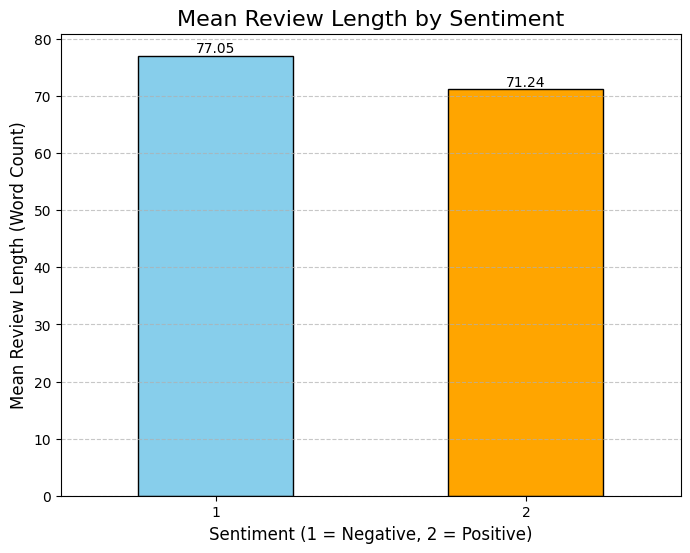

In [ ]:

# Create a bar chart
plt.figure(figsize=(8, 6))
average_lengths.plot(kind='bar', color=['skyblue', 'orange'], edgecolor='black')

plt.title('Mean Review Length by Sentiment', fontsize=16)
plt.xlabel('Sentiment (1 = Negative, 2 = Positive)', fontsize=12)
plt.ylabel('Mean Review Length (Word Count)', fontsize=12)
plt.xticks(rotation=0)  # Keep x-axis labels horizontal
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, v in enumerate(average_lengths):
    plt.text(i, v + 0.5, f'{v:.2f}', ha='center', fontsize=10)

plt.show()

In [41]:
stop_words = set(stopwords.words('english'))

positive_reviews = df[df['Label'] == 2]['Clean Review']

# Tokenize and remove stopwords
positive_tokens = [
    word for review in positive_reviews 
    for word in review.split() 
    if word not in stop_words
]

# Count the frequency of remaining words
positive_word_freq = Counter(positive_tokens)

most_common_positive = positive_word_freq.most_common(20)
print("Most common words in positive reviews:", most_common_positive)

Most common words in positive reviews: [('book', 98932), ('one', 67501), ('great', 64899), ('like', 51010), ('good', 50306), ('read', 38709), ('would', 34801), ('love', 33535), ('well', 33263), ('get', 30977), ('really', 30946), ('time', 30936), ('movie', 26102), ('best', 26100), ('first', 25481), ('much', 23841), ('cd', 23541), ('also', 23348), ('album', 22900), ('dont', 21580)]


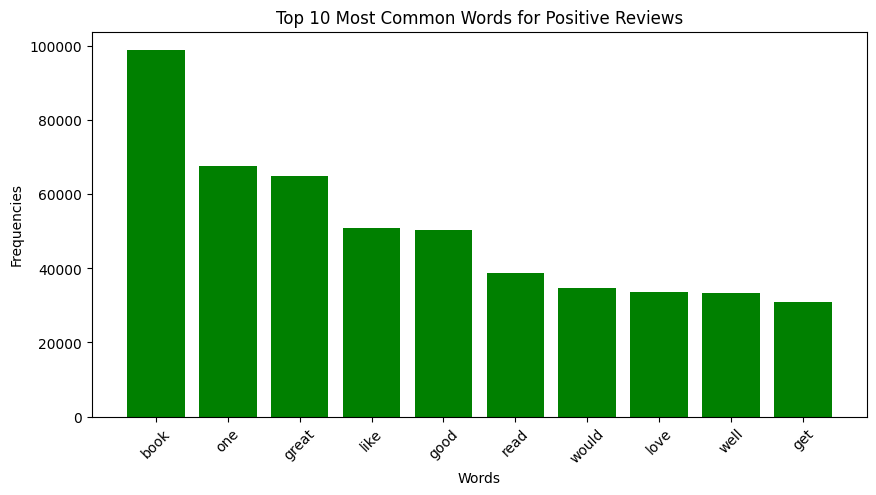

In [43]:
# Extract the top 10 most common positive words
top_10_positive = most_common_positive[:10]

# Separate the words and their frequencies
words, frequencies = zip(*top_10_positive)

# Create a bar plot
plt.figure(figsize=(10, 5))
plt.bar(words, frequencies, color='green')
plt.title('Top 10 Most Common Words for Positive Reviews')
plt.xlabel('Words')
plt.ylabel('Frequencies')
plt.xticks(rotation=45)
plt.show()

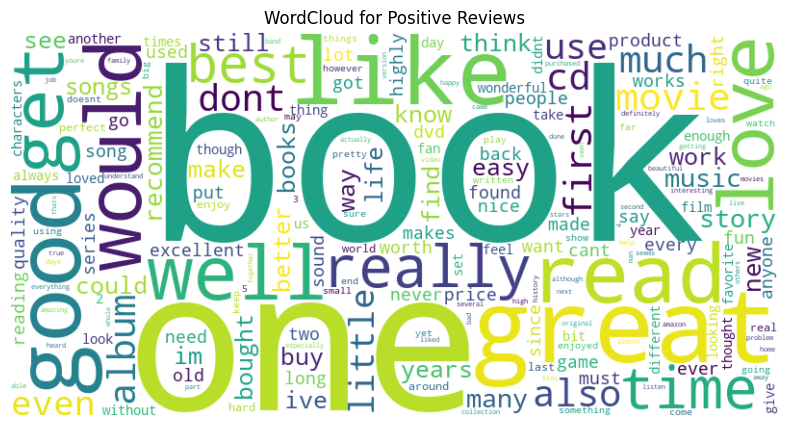

In [19]:
# Step 1: Create a dictionary of word frequencies
word_freq_dict = dict(positive_word_freq)

# Step 2: Generate the WordCloud
wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white', 
    colormap='viridis'
).generate_from_frequencies(word_freq_dict)

# Step 3: Display the WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off') 
plt.title("WordCloud for Positive Reviews")
plt.show()


In [25]:
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to get the WordNet POS tag
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

# Function to process and lemmatize a single review
def lemmatize_review(review):
    tokens = word_tokenize(review)  # Tokenize the review
    pos_tags = pos_tag(tokens)  # Get POS tags
    lemmatized_tokens = []  # List to store lemmatized tokens

    for word, tag in pos_tags:
        wordnet_tag = get_wordnet_pos(tag)  # Convert to WordNet POS
        if wordnet_tag:  # If valid POS tag, lemmatize the word
            lemmatized_tokens.append(lemmatizer.lemmatize(word, wordnet_tag))
        else:  # If no valid POS tag, keep the original word
            lemmatized_tokens.append(word)

    return lemmatized_tokens  # Return the list of lemmatized tokens

In [27]:
df['Lemmatization Token'] = df['Clean Review'].apply(lambda review: lemmatize_review(review))

In [28]:
df['Lemmatization Review'] = df['Lemmatization Token'].apply(lambda tokens: ' '.join(tokens))

In [29]:
# Step 1: Define the features (X) and target (y)
X = df['Lemmatization Review'] 
y = df['Label']                

# Step 2: Split into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,    
    random_state=42    
)

# Check the resulting shapes
print("Training set size:", X_train.shape[0])
print("Testing set size:", X_test.shape[0])

Training set size: 320000
Testing set size: 80000


In [30]:
# Step 1: Initialize the TfidfVectorizer
vectorizer = TfidfVectorizer(
    max_features=5000,  # Top 5000 features
    stop_words='english', 
    ngram_range=(1, 2)  # Bigrams
)

# Step 2: Fit on the training data and transform
tfidfX_train = vectorizer.fit_transform(X_train)

# Step 3: Transform the test data
tfidfX_test = vectorizer.transform(X_test)

# Check shapes
print("TF-IDF Training Data Shape:", tfidfX_train.shape)
print("TF-IDF Testing Data Shape:", tfidfX_test.shape)

TF-IDF Training Data Shape: (320000, 5000)
TF-IDF Testing Data Shape: (80000, 5000)


In [31]:
# Step 4: Train a Logistic Regression model
logistic_model = LogisticRegression(random_state=42, max_iter=1000)
logistic_model.fit(tfidfX_train, y_train)

# Step 5: Predict on the test data
y_pred = logistic_model.predict(tfidfX_test)



In [32]:
# Step 6: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.86

Classification Report:
              precision    recall  f1-score   support

           1       0.86      0.85      0.86     39896
           2       0.85      0.86      0.86     40104

    accuracy                           0.86     80000
   macro avg       0.86      0.86      0.86     80000
weighted avg       0.86      0.86      0.86     80000

